### Чтение данных

In [1]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import datetime as dtm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
import pickle

In [2]:
data_train = pd.read_csv('../data/data_train.csv')
data_test = pd.read_csv('../data/data_test.csv')

In [3]:
%%time
df_features = dd.read_csv('../data/features.csv', sep='\t')

CPU times: total: 0 ns
Wall time: 46.1 ms


### Визуальный просмотр данных и их размерностей

In [4]:
df_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [5]:
data_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [6]:
data_train['buy_time'].unique()

array([1537131600, 1531688400, 1534107600, 1535922000, 1532898000,
       1544994000, 1545598800, 1534712400, 1541970000, 1538341200,
       1533502800, 1541365200, 1539550800, 1536526800, 1546203600,
       1532293200, 1544389200, 1542574800, 1537736400, 1535317200,
       1540760400, 1531083600, 1538946000, 1540155600, 1543784400,
       1543179600], dtype=int64)

In [7]:
df_features['buy_time'].drop_duplicates().compute()

0      1531688400
1      1539550800
2      1545598800
3      1534107600
4      1533502800
6      1544994000
7      1537736400
9      1544389200
10     1536526800
11     1535317200
13     1534712400
14     1542574800
16     1540760400
18     1540155600
23     1541365200
26     1537131600
28     1531083600
33     1538341200
34     1532293200
40     1546203600
46     1535922000
51     1538946000
55     1547413200
57     1543784400
64     1548018000
67     1541970000
69     1532898000
148    1546808400
165    1543179600
Name: buy_time, dtype: int64

In [8]:
data_train.shape

(831653, 5)

In [9]:
%%time
df_features.shape[0].compute()

CPU times: total: 1min 21s
Wall time: 1min 20s


4512528

### Слияние данных

In [10]:
id_in_train = list(data_train.id)
id_in_test = list(data_test.id)

In [11]:
print(len(id_in_train))
print(len(id_in_test))

831653
71231


In [12]:
df_features.shape

(Delayed('int-ce531e14-5dbd-41fd-9f17-4bf6a42528c8'), 256)

In [13]:
%%time
df_features_for_train = df_features[df_features.id.isin(id_in_train)]

CPU times: total: 1.75 s
Wall time: 2.06 s


In [14]:
%%time
df_features_for_train_in_pd = df_features_for_train.compute()

CPU times: total: 1min 50s
Wall time: 1min 56s


In [15]:
df_features_for_train_in_pd.shape

(834168, 256)

In [16]:
%%time
df_features_for_test = df_features[df_features.id.isin(id_in_test)]

CPU times: total: 125 ms
Wall time: 143 ms


In [17]:
%%time
df_features_for_test_in_pd = df_features_for_test.compute()

CPU times: total: 1min 21s
Wall time: 1min 24s


In [18]:
df_features_for_test_in_pd.shape

(72552, 256)

In [19]:
data_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [20]:
sort_data_train = data_train.sort_values(by='id')
sort_df_features_for_train_in_pd = df_features_for_train_in_pd.sort_values(by='id')

In [21]:
sort_data_test = data_test.sort_values(by='id')
sort_df_features_for_test_in_pd = df_features_for_test_in_pd.sort_values(by='id')

In [22]:
%%time
full_train = pd.merge_asof(sort_data_train, sort_df_features_for_train_in_pd, on='id', by='buy_time', direction='nearest')

CPU times: total: 2.27 s
Wall time: 2.68 s


In [23]:
full_train.shape

(831653, 259)

In [24]:
%%time
full_test = pd.merge_asof(sort_data_test, sort_df_features_for_test_in_pd, on='id', by='buy_time', direction='nearest')

CPU times: total: 203 ms
Wall time: 268 ms


In [25]:
full_test.shape

(71231, 258)

In [26]:
full_test.head()

,Unnamed: 0_x,id,vas_id,buy_time,Unnamed: 0_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,87,55,2.0,1547413200,2266581,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,...,-977.373846,-613.770792,-24.996269,48.369552,-244.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
1,98,64,4.0,1548018000,3102545,-93.799971,-337.249112,-107.740786,-360.686798,-113.158246,...,934.626154,-611.770792,-25.996269,3571.369552,-120.747724,25.167111,-0.694428,-12.175933,-0.45614,1.0
2,278,151,2.0,1547413200,2266581,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,...,-977.373846,-613.770792,-24.996269,48.369552,-244.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
3,552,274,4.0,1548018000,3102545,-93.799971,-337.249112,-107.740786,-360.686798,-113.158246,...,934.626154,-611.770792,-25.996269,3571.369552,-120.747724,25.167111,-0.694428,-12.175933,-0.45614,1.0
4,551,274,2.0,1547413200,2266581,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,...,-977.373846,-613.770792,-24.996269,48.369552,-244.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0


In [27]:
# %%time
# full_train.reset_index(drop=True).to_csv('full_train.csv')
# full_test.reset_index(drop=True).to_csv('full_test.csv')

In [28]:
del df_features
del data_train
del df_features_for_train
del df_features_for_test
del df_features_for_train_in_pd
del df_features_for_test_in_pd
del sort_data_train
del sort_df_features_for_train_in_pd
del sort_data_test
del sort_df_features_for_test_in_pd

### Подготовка данных

In [29]:
# %%time
# full_train = pd.read_csv('full_train.csv')
# full_test = pd.read_csv('full_test.csv')

In [30]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Columns: 259 entries, Unnamed: 0_x to 252
dtypes: float64(255), int64(4)
memory usage: 1.6 GB


In [31]:
full_train.describe()

,Unnamed: 0_x,id,vas_id,buy_time,target,Unnamed: 0_y,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
count,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,831653.000000,831653.000000,831653.000000,...,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000
mean,415826.000000,2.158304e+06,2.686185,1.538937e+09,0.072369,2.254994e+06,2.062392,5.161329,1.987254,5.766886,...,-42.733928,-28.101598,-2.797341,-4.402215,-11.587021,-1.660674,-0.039381,0.884418,0.013525,0.268059
std,240077.686048,1.257907e+06,1.952034,5.019053e+06,0.259098,1.302122e+06,302.308236,495.918888,309.148563,576.275542,...,3110.526314,2146.368014,837.827712,245.841644,1231.708277,189.573153,7.176362,149.893098,18.732853,2.067714
min,0.000000,2.000000e+00,1.000000,1.531084e+09,0.000000,1.300000e+01,-1151.889971,-1447.969112,-2651.840786,-1488.716798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,207913.000000,1.067319e+06,1.000000,1.534108e+09,0.000000,1.127703e+06,-96.799971,-204.789112,-110.740786,-238.766798,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,415826.000000,2.144574e+06,2.000000,1.538341e+09,0.000000,2.251585e+06,-84.089971,-56.489112,-83.620786,-75.166798,...,-960.373846,-613.770792,-25.996269,-37.630448,-240.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,623739.000000,3.244254e+06,4.000000,1.544389e+09,0.000000,3.380386e+06,12.960029,123.190888,28.699214,131.583202,...,-517.373846,-423.770792,-24.996269,-33.630448,-83.747724,-10.832889,-0.694428,-8.175933,-0.456140,1.000000
max,831652.000000,4.362694e+06,9.000000,1.546204e+09,1.000000,4.512484e+06,211730.720029,212606.130888,211716.779214,213357.743202,...,161254.626154,145602.229208,214933.003731,37358.369552,141994.252276,34368.167111,2285.305572,33050.824067,9489.543860,1743.000000


In [32]:
# Столбцы 'Unnamed: 0_x' и 'Unnamed: 0_y' удалим, т.к. они не являются признаками, а отображают только порядок, индексы
full_train.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)
full_test.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)

In [33]:
name_columns_in_train = list(full_train.columns)
name_columns_in_train

['id',
 'vas_id',
 'buy_time',
 'target',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '13

In [34]:
full_len = full_train.shape[0]
for column_name in name_columns_in_train:
    if full_train[column_name].count() != full_len:
        count_nan = full_len - full_train[column_name].count()
        print('В столбце {column_name} пропущено {count_nan} значений')

В тренировочном датасете нет пропущенных данных

In [35]:
full_train.target.value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

Наблюдается сильный дисбаланс классов

In [36]:
sort_train = full_train.sort_values(by='buy_time')

In [37]:
print(dtm.datetime.fromtimestamp(min(sort_train.buy_time)))
print(dtm.datetime.fromtimestamp(max(sort_train.buy_time)))

2018-07-09 00:00:00
2018-12-31 00:00:00


In [38]:
max(sort_train.buy_time)

1546203600

In [39]:
int(dtm.datetime.strptime('01.12.2018 00:00:00', '%d.%m.%Y %H:%M:%S').timestamp())

1543611600

In [40]:
timestamp_separation = int(dtm.datetime.strptime('01.12.2018 00:00:00', '%d.%m.%Y %H:%M:%S').timestamp())
df_train = sort_train[sort_train.buy_time < timestamp_separation]
df_test = sort_train[sort_train.buy_time >= timestamp_separation]

In [41]:
df_train.target.value_counts()

0.0    546089
1.0     37984
Name: target, dtype: int64

In [42]:
df_test.target.value_counts()

0.0    225378
1.0     22202
Name: target, dtype: int64

In [43]:
X_train = df_train.drop(columns=['target'])
y_train = df_train.target
X_test = df_test.drop(columns=['target'])
y_test_real = df_test.target

In [44]:
del df_train
del df_test

In [45]:
list_name_features = list(X_train.columns)[3:]
list_name_features

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

In [46]:
# Функция создания, обучения модели, формирования предсказаний и подсчета метрик
def model_preds(model, X_train, y_train, X_test, y_test_real):
    model_class = RandomForestClassifier(random_state=21, class_weight={0 : 1, 1 : 10})
    model_class.fit(X_train, y_train)
    y_preds = model_class.predict(X_test)
    metrics = f1_score(y_test_real, y_preds, average='macro')
    return model_class, y_preds, metrics

In [47]:
# Датафрейм с результатами
columns_name = ['model', 'standart', 'with_std', 'with_PCA_and_std', 
                'for_slice', 'for_slice_with_std', 'for_slice_with_std_and_PCA']
df_metrics_for_models = pd.DataFrame(columns=columns_name)
df_metrics_for_models

,model,standart,with_std,with_PCA_and_std,for_slice,for_slice_with_std,for_slice_with_std_and_PCA


#### Рассмотрим модель Random Forest без дополнительных параметров

In [48]:
%%time
model_rf = RandomForestClassifier(random_state=21)
trained_model_rf, y_preds_rf, metrics_rf = model_preds(model_rf, X_train, y_train, X_test, y_test_real)
metrics_rf

CPU times: total: 6min 45s
Wall time: 7min 5s


0.512335365182574

Проверка модели Random Forest с весами для классов

In [49]:
%%time
model_rf_with_std = RandomForestClassifier(random_state=21, class_weight={0 : 1, 1 : 10})
trained_model_rf_with_std, y_preds_rf_with_std, metrics_rf_with_std = model_preds(model_rf_with_std, X_train, y_train, \
                                                                                  X_test, y_test_real)
metrics_rf_with_std

CPU times: total: 6min 24s
Wall time: 7min 22s


0.512335365182574

Стандартизируем данные

In [50]:
standard_scaler = StandardScaler()
X_std_train = X_train.copy()
X_std_train[list_name_features] = standard_scaler.fit_transform(X_std_train[list_name_features])

In [51]:
X_std_test = X_test.copy()
X_std_test[list_name_features] = standard_scaler.fit_transform(X_std_test[list_name_features])

In [52]:
%%time
model_rf_with_weight = RandomForestClassifier(random_state=21, class_weight={0.0 : 1, 1.0 : 10})
model_rf_with_weight.fit(X_std_train, y_train)
y_preds_rf_with_weight = model_rf_with_weight.predict(X_std_test)
f1_score(y_test_real, y_preds_rf_with_weight, average='macro')

CPU times: total: 6min 27s
Wall time: 6min 56s


0.4765285712473412

### При помощи модели Random Forest выявим наиболее важные признаки

In [53]:
X_std_train.columns

Index(['id', 'vas_id', 'buy_time', '0', '1', '2', '3', '4', '5', '6',
       ...
       '243', '244', '245', '246', '247', '248', '249', '250', '251', '252'],
      dtype='object', length=256)

In [54]:
df_feature_importance = pd.DataFrame({'feature': X_std_train.columns, 
                                      'importance': model_rf_with_weight.feature_importances_})

<AxesSubplot:>

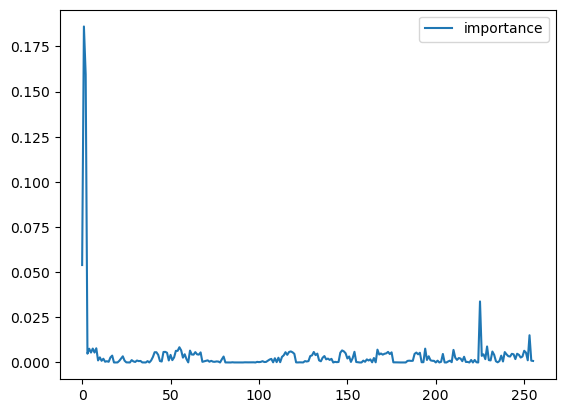

In [55]:
df_feature_importance.plot()

In [56]:
df_feature_importance.head()

,feature,importance
0,id,0.053944
1,vas_id,0.186014
2,buy_time,0.159406
3,0,0.004864
4,1,0.007617


In [57]:
df_feature_importance.sort_values(by='importance', ascending=False).head(100)

,feature,importance
1,vas_id,0.186014
2,buy_time,0.159406
0,id,0.053944
225,222,0.033788
253,250,0.015081
...,...,...
111,108,0.002633
136,133,0.002625
165,162,0.002476
213,210,0.002450


In [58]:
X_std_train[list(df_feature_importance[df_feature_importance.importance > 0.002].feature.values)]

,id,vas_id,buy_time,0,1,2,3,4,5,7,...,239,240,241,243,244,245,246,247,248,250
718885,3754749,2.0,1531083600,-0.068405,-0.036365,-0.107034,-0.078178,-0.122208,-0.110789,-0.129770,...,-0.170615,-0.013986,0.445761,-0.285279,-0.270987,-0.025689,-0.088033,0.009644,0.675686,0.729789
564859,2930695,2.0,1531083600,-0.123149,-0.353422,-0.124195,-0.347838,-0.138696,-0.355340,-0.156086,...,-0.036007,-0.265939,-0.266105,-0.302361,-0.274834,-0.026844,-0.148700,-0.196932,0.028859,0.061648
564860,2930697,2.0,1531083600,-0.123149,-0.353422,-0.124195,-0.347838,-0.138696,-0.355340,-0.156086,...,-0.036007,-0.265939,-0.266105,-0.302361,-0.274834,-0.026844,-0.148700,-0.196932,0.028859,0.061648
186657,957763,4.0,1531083600,-0.297409,0.152232,-0.331907,0.046398,-0.338258,0.002186,-0.156086,...,-0.172538,-0.006313,0.621601,0.260686,-0.144044,-0.022222,-0.143185,1.083295,0.339126,0.392912
564871,2930746,2.0,1531083600,-0.160300,0.528285,-0.197271,0.463005,-0.208905,0.379999,-0.144814,...,-0.172538,2.176850,1.736196,0.393399,0.586361,-0.025689,-0.121124,0.333098,0.049894,0.044805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59751,306400,4.0,1543179600,0.938833,-0.007307,1.138203,0.484194,1.074169,0.399215,-0.156086,...,-0.172538,-0.289599,-0.268941,-0.302361,-0.274834,-0.026844,-0.148700,-0.254012,-0.123644,-0.101176
58901,301892,6.0,1543179600,1.089254,0.157907,1.029740,0.566013,0.969962,0.473415,-0.156086,...,-0.045622,-0.289599,-0.268941,-0.302361,-0.274834,-0.026844,-0.148700,-0.203274,-0.076316,-0.101176
91785,471297,2.0,1543179600,-0.297409,-0.236900,-0.331907,-0.287854,-0.338258,-0.300941,-0.156086,...,-0.147539,-0.286402,-0.260433,-0.292506,-0.262332,-0.026844,-0.143185,0.046791,0.318091,-0.056259
471557,2439349,2.0,1543179600,-0.297409,-0.205767,-0.331907,-0.247733,-0.338258,-0.264556,-0.156086,...,-0.172538,1.352568,-0.087430,-0.228448,-0.174818,-0.026844,-0.148700,-0.042000,-0.113127,-0.101176


Построим модель random forest для части признаков

In [59]:
%%time
model_rf_for_slice = RandomForestClassifier(random_state=21)
trained_model_rf_for_slice, y_preds_rf_for_slice, metrics_rf_for_slice = model_preds(model_rf_for_slice, 
                     X_std_train[list(df_feature_importance[df_feature_importance.importance > 0.002].feature.values)], 
                     y_train, X_test[list(df_feature_importance[df_feature_importance.importance > 0.002].feature.values)],
                     y_test_real)
metrics_rf_for_slice

CPU times: total: 6min 29s
Wall time: 6min 55s


0.4765285712473412

Модель random forest для части признаков с переопределением весов целевой переменной

In [60]:
%%time
model_rf_for_slice_with_std = RandomForestClassifier(random_state=21, class_weight={0 : 1, 1 : 10})
trained_model_rf_for_slice_with_std, y_preds_rf_for_slice_with_std, metrics_rf_for_slice_with_std = model_preds(model_rf_for_slice_with_std, 
                     X_std_train[list(df_feature_importance[df_feature_importance.importance > 0.002].feature.values)], 
                     y_train, X_test[list(df_feature_importance[df_feature_importance.importance > 0.002].feature.values)], 
                     y_test_real)
metrics_rf_for_slice_with_std

CPU times: total: 6min 30s
Wall time: 6min 58s


0.4765285712473412

In [61]:
# Функция обучения pipeline, формирования предсказаний и подсчета метрик
def pipeline_preds(pipeline, X_train, y_train, X_test, y_test_real):
    pipeline.fit(X_train, y_train)
    y_preds = pipeline.predict(X_test)
    metrics = f1_score(y_test_real, y_preds, average='macro')
    return pipeline, y_preds, metrics

Создадим pipeline для модели random forest 

In [62]:
# %%time
# pipeline_rf_with_std = Pipeline([('standard_scaler', StandardScaler()), 
#                         ('random_forest', RandomForestClassifier(random_state=21))])
# trained_model_rf_with_std, y_preds_rf_with_std, metrics_rf_with_std = pipeline_preds(pipeline_rf_with_std, 
#                                          X_train, y_train, X_test, y_test_real)
# metrics_rf_with_std

Добавим PCA в pipeline для random forest

In [63]:
# %%time
# pipeline_rf_with_pca = Pipeline([('pca', PCA()),
#                         ('standard_scaler', StandardScaler()), 
#                         ('random_forest', RandomForestClassifier(random_state=21))])
# trained_model_rf_with_std_and_PCA, y_preds_rf_with_std_and_PCA, metrics_rf_with_std_and_PCA = pipeline_preds(pipeline_rf_with_pca, X_train, y_train, X_test, y_test_real)
# metrics_rf_with_std_and_PCA

Добавим PCA в pipeline для random forest для части признаков

In [64]:
X_train_slice = X_train[list(df_feature_importance[df_feature_importance.importance > 0.002].feature.values)]
X_test_slice = X_test[list(df_feature_importance[df_feature_importance.importance > 0.002].feature.values)]

In [65]:
# %%time
# pipeline_rf_slice_with_pca = Pipeline([('pca', PCA()),
#                         ('standard_scaler', StandardScaler()), 
#                         ('random_forest', RandomForestClassifier(random_state=21))])
# trained_model_rf_slice_with_std_and_PCA, y_preds_rf_slice_with_std_and_PCA, metrics_rf_slice_with_std_and_PCA = pipeline_preds(pipeline_rf_slice_with_pca, 
#                         X_train_slice, y_train, X_test_slice, y_test_real)
# metrics_rf_slice_with_std_and_PCA

Добавим результаты вычисления метрик в общий датафрейм

In [66]:
metrics_rf_with_std_and_PCA = np.nan
metrics_rf_slice_with_std_and_PCA = np.nan
result_for_rf = ['Random Forest', metrics_rf, metrics_rf_with_std, metrics_rf_with_std_and_PCA, 
                metrics_rf_for_slice, metrics_rf_for_slice_with_std, metrics_rf_slice_with_std_and_PCA]
df_result_for_rf = pd.DataFrame([result_for_rf], columns=columns_name)
df_metrics_for_models = pd.concat([df_metrics_for_models, df_result_for_rf], axis=0, ignore_index=True)
df_metrics_for_models

,model,standart,with_std,with_PCA_and_std,for_slice,for_slice_with_std,for_slice_with_std_and_PCA
0,Random Forest,0.512335,0.512335,NaN,0.476529,0.476529,NaN


#### Рассмотрим алгоритм logistic regression

In [67]:
%%time
pipeline_lr = Pipeline([('logistic_regression', LogisticRegression(random_state=21))])
trained_model_lr, y_preds_lr, metrics_lr = pipeline_preds(pipeline_lr, X_train, y_train, X_test, y_test_real)
metrics_lr

CPU times: total: 43.8 s
Wall time: 16.2 s


0.4765285712473412

Добавим в logistic regression стандартизацию

In [68]:
%%time
pipeline_lr_with_std = Pipeline([('standard_scaler', StandardScaler()), 
                        ('logistic_regression', LogisticRegression(random_state=21))])
trained_model_lr_with_std, y_preds_lr_with_std, metrics_lr_with_std = pipeline_preds(pipeline_lr_with_std, 
                        X_train, y_train, X_test, y_test_real)
metrics_lr_with_std

CPU times: total: 40.7 s
Wall time: 17.3 s


0.5985759673249568

Добавим в logistic regression стандартизацию и PCA

In [69]:
%%time
pipeline_lr_with_std_pca = Pipeline([('pca', PCA()),
                                   ('standard_scaler', StandardScaler()), 
                                    ('logistic_regression', LogisticRegression(random_state=21))])
trained_model_lr_with_std_pca, y_preds_lr_with_std_pca, metrics_lr_with_std_pca = pipeline_preds(pipeline_lr_with_std_pca, 
                                    X_train, y_train, X_test, y_test_real)
metrics_lr_with_std_pca

CPU times: total: 1min 10s
Wall time: 28.2 s


0.588490112775266

Рассмотрим logistic regression для ограниченного набора признаков

In [70]:
%%time
pipeline_lr_slice = Pipeline([('logistic_regression', LogisticRegression(random_state=21))])
trained_model_lr_slice, y_preds_lr_slice, metrics_lr_slice = pipeline_preds(pipeline_lr_slice, 
                                                X_train_slice, y_train, X_test_slice, y_test_real)
metrics_lr_slice

CPU times: total: 17.9 s
Wall time: 6.93 s


0.4765285712473412

Добавим в logistic regression для ограниченного набора признаков стандартизацию

In [71]:
%%time
pipeline_lr_slice_with_std = Pipeline([('standard_scaler', StandardScaler()), 
                        ('logistic_regression', LogisticRegression(random_state=21))])
trained_model_lr_slice_with_std, y_preds_lr_slice_with_std, metrics_lr_slice_with_std = pipeline_preds(pipeline_lr_slice_with_std, 
                        X_train_slice, y_train, X_test_slice, y_test_real)
metrics_lr_slice_with_std

CPU times: total: 23.9 s
Wall time: 9.33 s


0.6002338829980377

Добавим в logistic regression для ограниченного набора признаков стандартизацию и PCA

In [72]:
%%time
pipeline_lr_slice_with_std_pca = Pipeline([('pca', PCA()),
                                   ('standard_scaler', StandardScaler()), 
                                    ('logistic_regression', LogisticRegression(random_state=21))])
trained_model_lr_slice_with_std_pca, y_preds_lr_slice_with_std_pca, metrics_lr_slice_with_std_pca = pipeline_preds(pipeline_lr_slice_with_std_pca, 
                                    X_train_slice, y_train, X_test_slice, y_test_real)
metrics_lr_slice_with_std_pca

CPU times: total: 19.6 s
Wall time: 8.24 s


0.5988148028575941

In [73]:
result_for_logreg = ['Logistic Regression', metrics_lr, metrics_lr_with_std, metrics_lr_with_std_pca, 
                metrics_lr_slice, metrics_lr_slice_with_std, metrics_lr_slice_with_std_pca]
df_result_for_logreg = pd.DataFrame([result_for_logreg], columns=columns_name)
df_metrics_for_models = pd.concat([df_metrics_for_models, df_result_for_logreg], axis=0, ignore_index=True)
df_metrics_for_models

,model,standart,with_std,with_PCA_and_std,for_slice,for_slice_with_std,for_slice_with_std_and_PCA
0,Random Forest,0.512335,0.512335,NaN,0.476529,0.476529,NaN
1,Logistic Regression,0.476529,0.598576,0.58849,0.476529,0.600234,0.598815


#### Рассмотрим модель Gradient Boosting

In [74]:
%%time
pipeline_gb = Pipeline([('gradient_boosting', GradientBoostingClassifier(random_state=21))])
trained_model_gb, y_preds_gb, metrics_gb = pipeline_preds(pipeline_gb, X_train, y_train, X_test, y_test_real)
metrics_gb

CPU times: total: 16min 11s
Wall time: 17min 20s


0.7394367422235442

Добавим стандартизацию данных в модель Gradient Boosting

In [75]:
%%time
pipeline_gb_with_std = Pipeline([('standard_scaler', StandardScaler()), 
                                ('gradient_boosting', GradientBoostingClassifier(random_state=21))])
trained_model_gb_with_std, y_preds_gb_with_std, metrics_gb_with_std = pipeline_preds(pipeline_gb_with_std, 
                                    X_train, y_train, X_test, y_test_real)
metrics_gb_with_std

CPU times: total: 16min 13s
Wall time: 17min 17s


0.7394367422235442

Добавим стандартизацию данных и PCA в модель Gradient Boosting

In [76]:
# %%time
# pipeline_gb_with_std_pca = Pipeline([('pca', PCA()),
#                                 ('standard_scaler', StandardScaler()), 
#                                 ('gradient_boosting', GradientBoostingClassifier(random_state=21))])
# trained_model_gb_with_std_pca, y_preds_gb_with_std_pca, metrics_gb_with_std_pca = pipeline_preds(pipeline_gb_with_std_pca, 
#                                     X_train, y_train, X_test, y_test_real)
# metrics_gb_with_std_pca

Рассмотрим модель Gradient Boosting для отобранной части признаков

In [77]:
%%time
pipeline_gb_slice = Pipeline([('gradient_boosting', GradientBoostingClassifier(random_state=21))])
trained_model_gb_slice, y_preds_gb_slice, metrics_gb_slice = pipeline_preds(pipeline_gb_slice, X_train_slice, 
                                                                            y_train, X_test_slice, y_test_real)
metrics_gb_slice

CPU times: total: 13min 5s
Wall time: 13min 55s


0.7359354691652424

Рассмотрим модель Gradient Boosting со стандартизацией данных для отобранной части признаков

In [78]:
%%time
pipeline_gb_slice_with_std = Pipeline([('standard_scaler', StandardScaler()), 
                                ('gradient_boosting', GradientBoostingClassifier(random_state=21))])
trained_model_gb_slice_with_std, y_preds_gb_slice_with_std, metrics_gb_slice_with_std = pipeline_preds(pipeline_gb_slice_with_std, 
                                    X_train_slice, y_train, X_test_slice, y_test_real)
metrics_gb_slice_with_std

CPU times: total: 12min 51s
Wall time: 13min 55s


0.7359295416947829

Рассмотрим модель Gradient Boosting со стандартизацией данных и PCA для отобранной части признаков

In [79]:
# %%time
# pipeline_gb_with_slice_std_pca = Pipeline([('pca', PCA()),
#                                 ('standard_scaler', StandardScaler()), 
#                                 ('gradient_boosting', GradientBoostingClassifier(random_state=21))])
# trained_model_gb_slice_with_std_pca, y_preds_gb_slice_with_std_pca, metrics_gb_slice_with_std_pca = pipeline_preds(pipeline_gb_slice_with_std_pca, 
#                                     X_train_slice, y_train, X_test_slice, y_test_real)
# metrics_gb_slice_with_std_pca

In [80]:
metrics_gb_with_std_pca = np.nan
metrics_gb_slice_with_std_pca = np.nan
result_for_gb = ['Gradient Boosting', metrics_gb, metrics_gb_with_std, metrics_gb_with_std_pca, 
                metrics_gb_slice, metrics_gb_slice_with_std, metrics_gb_slice_with_std_pca]
df_result_for_gb = pd.DataFrame([result_for_gb], columns=columns_name)
df_metrics_for_models = pd.concat([df_metrics_for_models, df_result_for_gb], axis=0, ignore_index=True)
df_metrics_for_models

,model,standart,with_std,with_PCA_and_std,for_slice,for_slice_with_std,for_slice_with_std_and_PCA
0,Random Forest,0.512335,0.512335,NaN,0.476529,0.476529,NaN
1,Logistic Regression,0.476529,0.598576,0.58849,0.476529,0.600234,0.598815
2,Gradient Boosting,0.739437,0.739437,NaN,0.735935,0.735930,NaN


#### Рассмотрим алгоритм knn

In [81]:
%%time
pipeline_knn = Pipeline([('knn', KNeighborsClassifier())])
trained_model_knn, y_preds_knn, metrics_knn = pipeline_preds(pipeline_knn, X_train, y_train, X_test, y_test_real)
metrics_knn

CPU times: total: 1h 8min 39s
Wall time: 46min 57s


0.5026651336703677

Добавим к алгоритму knn стандартизацию

In [82]:
%%time
pipeline_knn_std = Pipeline([('standard_scaler', StandardScaler()), 
                                ('knn', KNeighborsClassifier())])
trained_model_knn_std, y_preds_knn_with_std, metrics_knn_with_std = pipeline_preds(pipeline_knn_std, X_train, y_train,
                                                                                   X_test, y_test_real)
metrics_knn_with_std

CPU times: total: 1h 11min 37s
Wall time: 50min 30s


0.5287948164990199

Добавим к алгоритму knn стандартизацию и PCA

In [83]:
# %%time
# pipeline_knn_std_pca = Pipeline([('pca', PCA()),
#                                 ('standard_scaler', StandardScaler()), 
#                                 ('knn', KNeighborsClassifier())])
# trained_model_knn_with_std_pca, y_preds_knn_with_std_pca, metrics_knn_with_std_pca = pipeline_preds(pipeline_knn_with_std_pca, 
#                                     X_train, y_train, X_test, y_test_real)
# metrics_knn_with_std_pca

Применим алгоритм knn к ограниченному набору признаков

In [84]:
%%time
pipeline_knn_with_slice = Pipeline([('knn', KNeighborsClassifier())])
trained_model_knn_slice, y_preds_knn_slice, metrics_knn_slice = pipeline_preds(pipeline_knn_with_slice, 
                                    X_train_slice, y_train, X_test_slice, y_test_real)
metrics_knn_slice

CPU times: total: 50min 45s
Wall time: 40min 27s


0.5017611761540611

Добавим к алгоритму knn для ограниченного набора признаков стандартизацию

In [85]:
# %%time
# pipeline_knn_with_slice_std = Pipeline([('standard_scaler', StandardScaler()), 
#                                 ('knn', KNeighborsClassifier())])
# trained_model_knn_slice_with_std, y_preds_knn_slice_with_std, metrics_knn_slice_with_std = pipeline_preds(pipeline_knn_with_slice_std, 
#                                     X_train_slice, y_train, X_test_slice, y_test_real)
# metrics_knn_slice_with_std

Рассмотрим модель knn со стандартизацией данных и PCA для отобранной части признаков

In [86]:
# %%time
# pipeline_knn_with_slice_std_pca = Pipeline([('pca', PCA()),
#                                 ('standard_scaler', StandardScaler()), 
#                                 ('knn', KNeighborsClassifier())])
# trained_model_knn_slice_with_std_pca, y_preds_knn_slice_with_std_pca, metrics_knn_slice_with_std_pca = pipeline_preds(pipeline_knn_with_slice_std_pca, 
#                                     X_train_slice, y_train, X_test_slice, y_test_real)
# metrics_knn_slice_with_std_pca

In [87]:
metrics_knn_with_std_pca = np.nan
metrics_knn_slice_with_std = np.nan
metrics_knn_slice_with_std_pca = np.nan
result_for_knn = ['K Neighbors Classifier', metrics_knn, metrics_knn_with_std, metrics_knn_with_std_pca, 
                metrics_knn_slice, metrics_knn_slice_with_std, metrics_knn_slice_with_std_pca]
df_result_for_knn = pd.DataFrame([result_for_knn], columns=columns_name)
df_metrics_for_models = pd.concat([df_metrics_for_models, df_result_for_knn], axis=0, ignore_index=True)
df_metrics_for_models

,model,standart,with_std,with_PCA_and_std,for_slice,for_slice_with_std,for_slice_with_std_and_PCA
0,Random Forest,0.512335,0.512335,NaN,0.476529,0.476529,NaN
1,Logistic Regression,0.476529,0.598576,0.58849,0.476529,0.600234,0.598815
2,Gradient Boosting,0.739437,0.739437,NaN,0.735935,0.735930,NaN
3,K Neighbors Classifier,0.502665,0.528795,NaN,0.501761,NaN,NaN


Наилучший результат дала модель GradientBoostingClassifier без стандартизации. Подберем гиперпараметры для этой модели

In [88]:
%%time
parameters = {'n_estimators': [50, 100, 200], 'max_depth': [1, 3, 5]}
model_gb = GradientBoostingClassifier(random_state=21)
f1 = make_scorer(f1_score, average='macro')
grid_search_for_gb = GridSearchCV(model_gb, parameters, scoring=f1)
grid_search_for_gb.fit(X_train, y_train)

KeyboardInterrupt: 

In [89]:
grid_search_for_gb.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
grid_search_for_gb.cv_results_

### Финальное обучение модели, сохранение модели и выполнение предсказания

In [ ]:
X_train_final = full_train.drop(columns=['target'])
y_train_final = full_train.target

In [ ]:
del full_train

In [ ]:
best_model = GradientBoostingClassifier(random_state=21, max_depth=1, n_estimators=100)

In [ ]:
best_model.fit(X_train_final, y_train_final)

In [ ]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
y_predict_final = best_model.predict(full_test)

In [ ]:
full_test_result['target'] = y_predict_final

In [ ]:
result = full_test_result[['id', 'vas_id', 'buy_time', 'target']].reset_index(drop=True)

In [ ]:
result.head()

In [ ]:
result.to_csv('answers_test.csv')

In [ ]:
with open('best_model.pkl', 'rb') as file: 
    pickle_model = pickle.load(file) 

In [ ]:
pickle_model.predict(full_test)